In [155]:
!git clone https://github.com/XL2248/MSCTD
# copy needed 
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!pip -q install --upgrade --no-cache-dir gdown
!gdown --id 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
!gdown --id 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
!gdown --id 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
!unzip train_ende.zip
!unzip dev.zip
!unzip test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Streaming output truncated to the last 5000 lines.
  inflating: test/1061.jpg           
  inflating: test/1062.jpg           
  inflating: test/1063.jpg           
  inflating: test/1064.jpg           
  inflating: test/1065.jpg           
  inflating: test/1066.jpg           
  inflating: test/1067.jpg           
  inflating: test/1068.jpg           
  inflating: test/1069.jpg           
  inflating: test/107.jpg            
  inflating: test/1070.jpg           
  inflating: test/1071.jpg           
  inflating: test/1072.jpg           
  inflating: test/1073.jpg           
  inflating: test/1074.jpg           
  inflating: test/1075.jpg           
  inflating: test/1076.jpg           
  inflating: test/1077.jpg           
  inflating: test/1078.jpg           
  inflating: test/1079.jpg           
  inflating: test/108.jpg            
  inflating: test/1080.jpg           
  inflating: test/1081.jpg           
  inflating: test/1082.jpg           
  inflating: test/1083.jpg           

In [107]:
import torchvision
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import cv2
!pip install facenet-pytorch
from facenet_pytorch import MTCNN

In [108]:
class MSCTD(Dataset):
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_image=True, has_text=True, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        """
        :param root: root path of the dataset
        :param split: train, dev, test
        :param image_transform: transform for image
        :param text_transform: transform for text
        :param sentiment_transform: transform for sentiment
        :param has_image: if the dataset has image
        :param has_text: if the dataset has text
        :param text_path: path of the text file
        :param image_path: path of the image folder
        :param sentiment_path: path of the sentiment file
        :param image_index_path: path of the image index file

        :return: combination of image, sentiment, text, image_index
        """
        self.root = root
        self.split = split
        if has_image:
            self.image = []
            self.image_transform = image_transform
            if image_path is None:
                self.image_path = os.path.join(root, split, 'image')
            else:
                self.image_path = os.path.join(root, image_path)
        if has_text:
            self.text = []
            self.text_transform = text_transform
            if text_path is None:
                self.text_path = os.path.join(root, split, 'english_' + split + '.txt')
            else:
                self.text_path = os.path.join(root, text_path)
        if sentiment_path is None:
            self.sentiment_path = os.path.join(root, split, 'sentiment_' + split + '.txt')
        else:
            self.sentiment_path = os.path.join(root, sentiment_path)
        if image_index_path is None:
            self.image_index_path = os.path.join(root, split, 'image_index_' + split + '.txt')
        else:
            self.image_index_path = os.path.join(root, image_index_path)
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        with open(self.sentiment_path, 'r') as f:
            for line in f:
                self.sentiment.append(int(line.strip()))
        if hasattr(self, 'text'):
            with open(self.text_path, 'r') as f:
                for line in f:
                    self.text.append(line.strip())
        with open(self.image_index_path, 'r') as f:
            for line in f:
                index = line.strip()[1:-1].split(', ')
                index = [int(i) for i in index]
                self.image_index.append(index)
        # if the class has image attribute, append image to self.image
        # the method to load images must not result in a too many open files error
        # use read_image instead of Image.open
        # the images are in self.image_path
                    
    def __getitem__(self, index):
        if hasattr(self, 'image'):
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if hasattr(self, 'text'):
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        sentiment = self.sentiment[index]
        # image_index = self.image_index[index]
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        # if the class has image and text attribute return image, text, sentiment
        if hasattr(self, 'image') and hasattr(self, 'text'):
            return image, text, sentiment
        # if the class has image attribute return image, sentiment
        elif hasattr(self, 'image'):
            return image, sentiment
        # if the class has text attribute return text, sentiment
        elif hasattr(self, 'text'):
            return text, sentiment
        else:
            raise Exception('Either has_image or has_text should be True')


    def __len__(self):
        return len(self.sentiment)
    

In [137]:
# create a transform for image that converts the uint8 tensor to float32 and devides by 255
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform)
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform)
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform)

In [111]:
# create a dataframe for each split
train_df = pd.DataFrame({'text': MSCTD_train.text, 'sentiment': MSCTD_train.sentiment})
dev_df = pd.DataFrame({'text': MSCTD_dev.text, 'sentiment': MSCTD_dev.sentiment})
test_df = pd.DataFrame({'text': MSCTD_test.text, 'sentiment': MSCTD_test.sentiment})

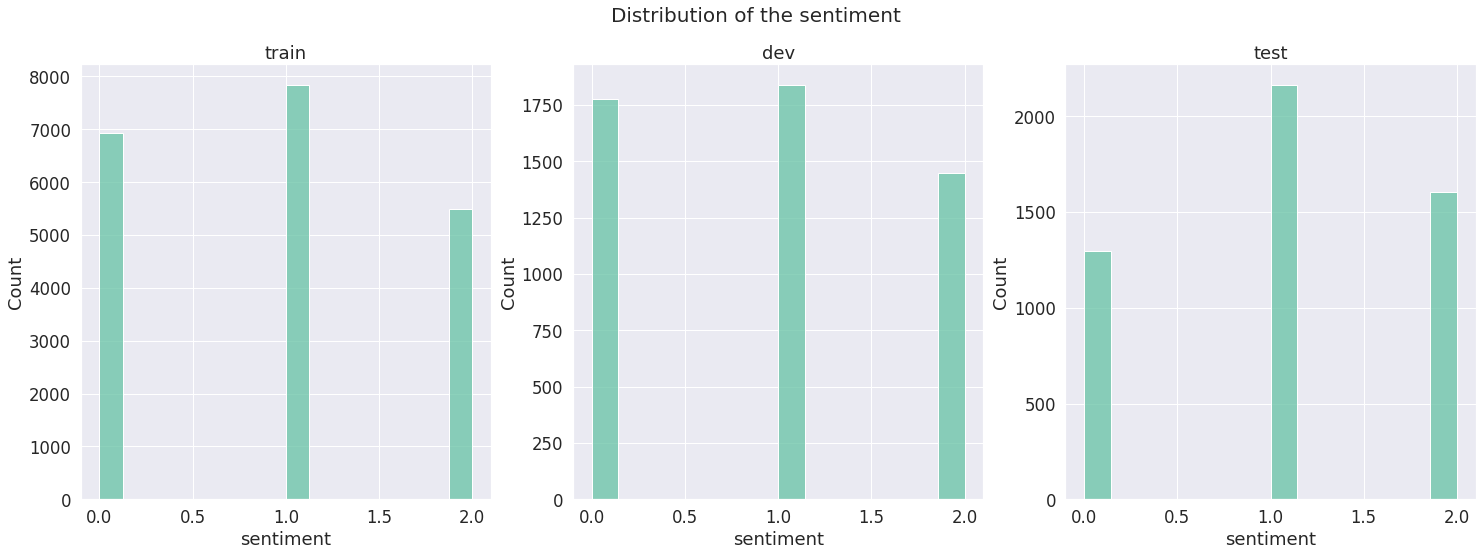

In [112]:
# plot the distribution of the sentiment
sns.set_theme(style="darkgrid")
sns.set(font_scale=1.5)
sns.set_palette("Set2")
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the sentiment', fontsize=20)
sns.histplot(train_df['sentiment'], ax=ax[0])
ax[0].set_title('train')
sns.histplot(dev_df['sentiment'], ax=ax[1])
ax[1].set_title('dev')
sns.histplot(test_df['sentiment'], ax=ax[2])
ax[2].set_title('test')
plt.show()



In [113]:
# add a new column to the dataframe with the length of the text
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
dev_df['text_length'] = dev_df['text'].apply(lambda x: len(x.split()))
test_df['text_length'] = test_df['text'].apply(lambda x: len(x.split()))

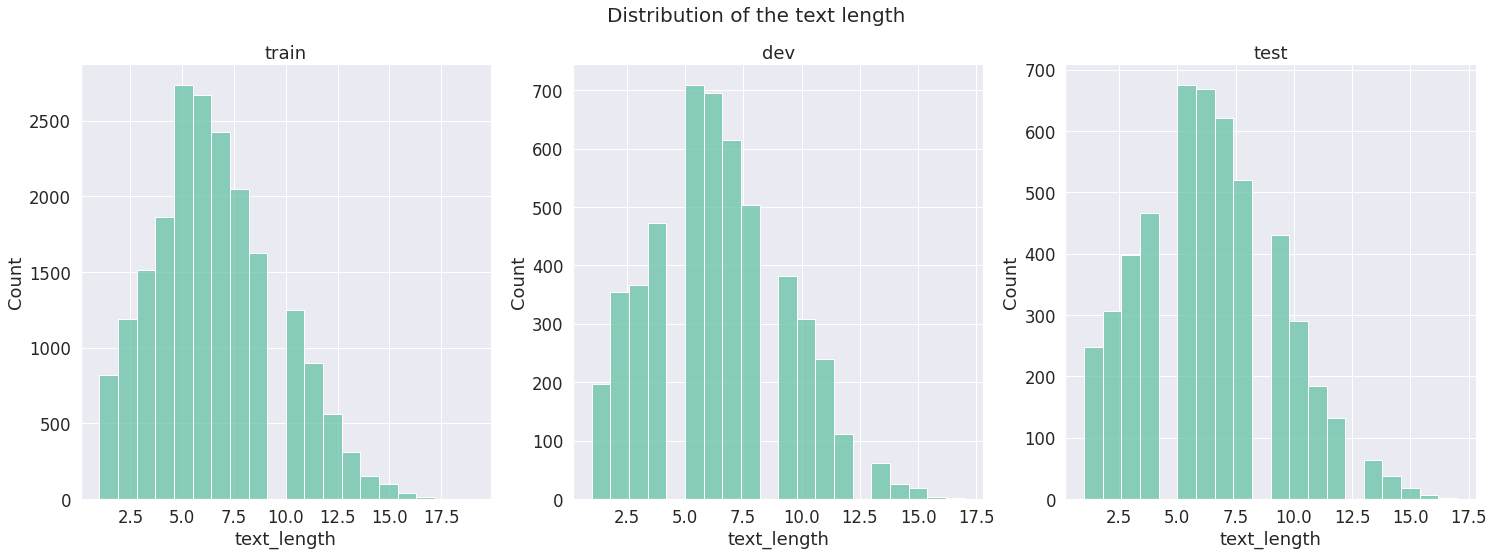

train mean:  6.4644268774703555
train std:  3.0410046435586535
dev mean:  6.310290341694648
dev std:  2.9381055492157224
test mean:  6.303927373199132
test std:  2.9823785621767294


In [114]:
# plot the distribution of the text length
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Distribution of the text length', fontsize=20)
sns.histplot(train_df['text_length'], ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_df['text_length'], ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_df['text_length'], ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
# print the mean and standard deviation of the text length
print('train mean: ', train_df['text_length'].mean())
print('train std: ', train_df['text_length'].std())
print('dev mean: ', dev_df['text_length'].mean())
print('dev std: ', dev_df['text_length'].std())
print('test mean: ', test_df['text_length'].mean())
print('test std: ', test_df['text_length'].std())

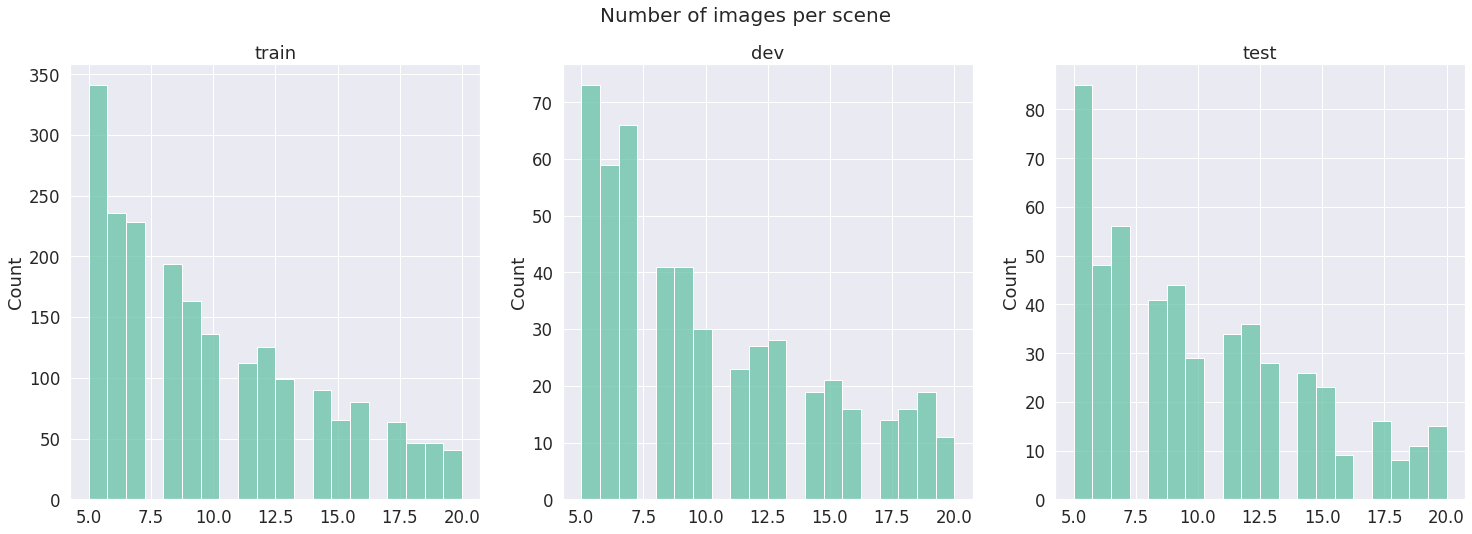

train mean:  9.796708615682478
train std:  4.206700598078209
dev mean:  10.045634920634921
dev std:  4.3879231801583565
test mean:  9.954813359528487
test std:  4.213357164986483


In [115]:
train_imgs_per_scene = [len(i) for i in MSCTD_train.image_index]
dev_imgs_per_scene = [len(i) for i in MSCTD_dev.image_index]
test_imgs_per_scene = [len(i) for i in MSCTD_test.image_index]
# plot the distribution of the number of images per scene
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Number of images per scene', fontsize=20)
sns.histplot(train_imgs_per_scene, ax=ax[0], bins=20)
ax[0].set_title('train')
sns.histplot(dev_imgs_per_scene, ax=ax[1], bins=20)
ax[1].set_title('dev')
sns.histplot(test_imgs_per_scene, ax=ax[2], bins=20)
ax[2].set_title('test')
plt.show()
print('train mean: ', np.mean(train_imgs_per_scene))
print('train std: ', np.std(train_imgs_per_scene))
print('dev mean: ', np.mean(dev_imgs_per_scene))
print('dev std: ', np.std(dev_imgs_per_scene))
print('test mean: ', np.mean(test_imgs_per_scene))
print('test std: ', np.std(test_imgs_per_scene))

In [157]:
batch_size = 32
train_loader = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

In [159]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
def num_faces(boxes):
  return [0 if i is None else len(i) for i in boxes]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)
train_faces_per_img = []
dev_faces_per_img = []
test_faces_per_img = []
counter = 0
with torch.no_grad():
  for image, text, sentiment in train_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    train_faces_per_img.append(num_faces(boxes))
    counter += 1
    print(f"batch {counter}/{len(train_loader)}")
  print("train done")
  counter = 0
  for image, text, sentiment in dev_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    dev_faces_per_img.append(num_faces(boxes))
    counter += 1
    print(f"batch {counter}/{len(dev_loader)}")
  print("dev done")
  counter = 0
  for image, text, sentiment in test_loader:
    image = image.to(device)
    boxes, _ = mtcnn.detect(image)
    test_faces_per_img.append(num_faces(boxes))
    counter += 1
    print(f"batch {counter}/{len(test_loader)}")
  print("test done")

batch 1/633
batch 2/633
batch 3/633
batch 4/633
batch 5/633
batch 6/633
batch 7/633
batch 8/633
batch 9/633
batch 10/633
batch 11/633
batch 12/633
batch 13/633
batch 14/633
batch 15/633
batch 16/633
batch 17/633
batch 18/633
batch 19/633
batch 20/633
batch 21/633
batch 22/633
batch 23/633
batch 24/633
batch 25/633
batch 26/633
batch 27/633
batch 28/633
batch 29/633
batch 30/633
batch 31/633
batch 32/633
batch 33/633
batch 34/633
batch 35/633
batch 36/633
batch 37/633
batch 38/633
batch 39/633
batch 40/633
batch 41/633
batch 42/633
batch 43/633
batch 44/633
batch 45/633
batch 46/633
batch 47/633
batch 48/633
batch 49/633
batch 50/633
batch 51/633
batch 52/633
batch 53/633
batch 54/633
batch 55/633
batch 56/633
batch 57/633
batch 58/633
batch 59/633
batch 60/633
batch 61/633
batch 62/633
batch 63/633
batch 64/633
batch 65/633
batch 66/633
batch 67/633
batch 68/633
batch 69/633
batch 70/633
batch 71/633
batch 72/633
batch 73/633
batch 74/633
batch 75/633
batch 76/633
batch 77/633
batch 78

In [160]:
train_faces_per_img = [item for sublist in train_faces_per_img for item in sublist]
dev_faces_per_img = [item for sublist in dev_faces_per_img for item in sublist]
test_faces_per_img = [item for sublist in test_faces_per_img for item in sublist]
print('train mean: ', np.mean(train_faces_per_img))
print('train std: ', np.std(train_faces_per_img))
print('dev mean: ', np.mean(dev_faces_per_img))
print('dev std: ', np.std(dev_faces_per_img))
print('test mean: ', np.mean(test_faces_per_img))
print('test std: ', np.std(test_faces_per_img))

train mean:  1.5254446640316206
train std:  2.0476644364180214
dev mean:  1.4540786095200473
dev std:  3.476198613380265
test mean:  1.5261495954213538
test std:  1.475628279594663


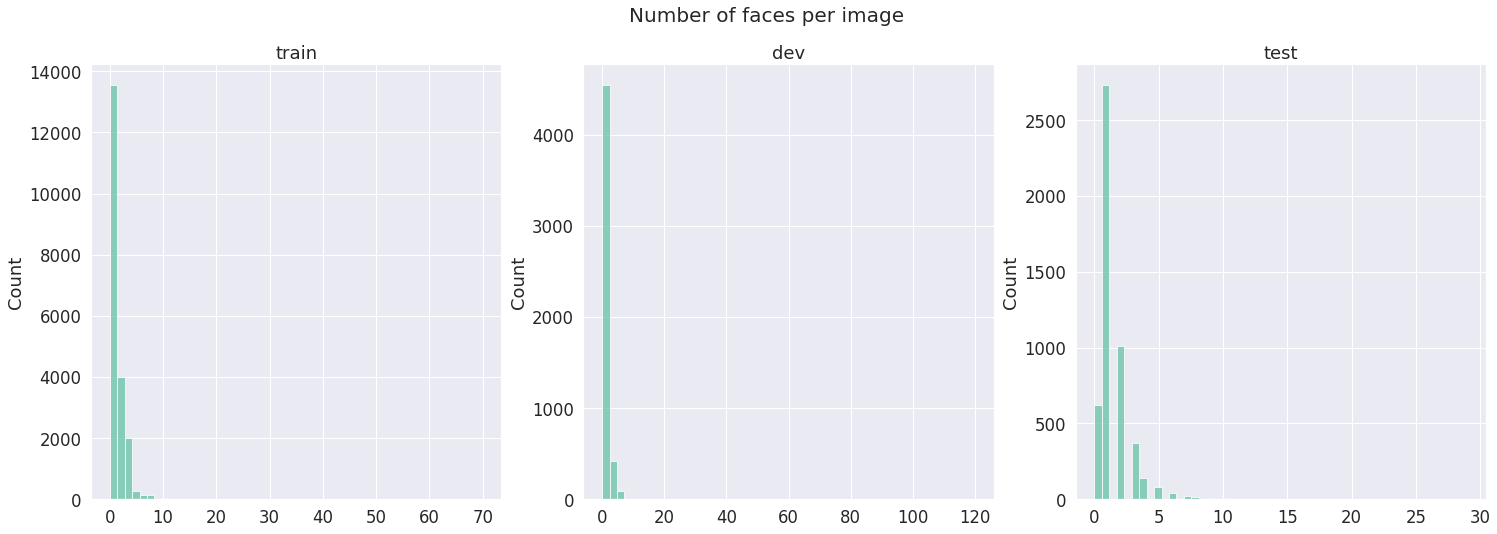

In [165]:
# plot the distribution of the number of faces per image
fig, ax = plt.subplots(1, 3, figsize=(25, 8))
bins = 50
fig.suptitle('Number of faces per image', fontsize=20)
sns.histplot(train_faces_per_img, ax=ax[0], bins=bins)
ax[0].set_title('train')
sns.histplot(dev_faces_per_img, ax=ax[1], bins=bins)
ax[1].set_title('dev')
sns.histplot(test_faces_per_img, ax=ax[2], bins=bins)
ax[2].set_title('test')
plt.show()


In [173]:
# what is the average length of the conversation
train_conv_len = [len(i) for i in MSCTD_train.image_index]
dev_conv_len = [len(i) for i in MSCTD_dev.image_index]
test_conv_len = [len(i) for i in MSCTD_test.image_index]
print('train mean: ', np.mean(train_conv_len))
print('train std: ', np.std(train_conv_len))
print('dev mean: ', np.mean(dev_conv_len))
print('dev std: ', np.std(dev_conv_len))
print('test mean: ', np.mean(test_conv_len))

train mean:  9.796708615682478
train std:  4.206700598078209
dev mean:  10.045634920634921
dev std:  4.3879231801583565
test mean:  9.954813359528487


In [174]:
train_sentiment = []
dev_sentiment = []
test_sentiment = []
for i in MSCTD_train.image_index:
    train_sentiment.append([MSCTD_train.sentiment[j] for j in i])
for i in MSCTD_dev.image_index:
    dev_sentiment.append([MSCTD_dev.sentiment[j] for j in i])
for i in MSCTD_test.image_index:
    test_sentiment.append([MSCTD_test.sentiment[j] for j in i])

In [183]:
def sentiment_change(sentiment_index):
    change = []
    for i in sentiment_index:
        temp = [i[0]]
        for j in range(len(i)-1):
            if i[j] != i[j+1]:
                temp.append(i[j+1])
        change.append(temp)
    return change

train_change = sentiment_change(train_sentiment)
dev_change = sentiment_change(dev_sentiment)
test_change = sentiment_change(test_sentiment)

In [182]:
print(train_sentiment)
print(train_change)

[[0, 0, 1, 1, 1], [2, 1, 1, 0, 1], [1, 1, 1, 1, 1, 1, 2], [1, 2, 0, 0, 0], [1, 1, 1, 1, 0], [2, 0, 1, 1, 0], [0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2], [0, 0, 1, 1, 1, 2, 2, 1, 0], [0, 0, 0, 1, 1, 1], [0, 1, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1], [1, 2, 0, 1, 0], [2, 0, 1, 0, 1, 1, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 1, 1], [2, 0, 1, 2, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1], [2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 0], [0, 0, 2, 1, 0], [1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2], [1, 1, 1, 2, 2, 0], [2, 2, 1, 2, 2, 2, 1, 1, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2], [0, 0, 2, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0], [0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 0, 0, 2], [1, 1, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [1, 1, 1, 2, 2, 2, 0, 1], [0, 0, 2, 2, 1, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1], [0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [2, 0, 1, 2, 0, 2, 1, 0], [0, 2, 0, 0, 0, 0, 1, 1, 0, 0], [2, 2, 0, 1, 0, 0, 1, 1, 1, 1],

In [202]:
train_change_set = []
train_change_count = []
for i in train_change:
    if i not in train_change_set:
        train_change_set.append(i)
        train_change_count.append(1)
    else:
        train_change_count[train_change_set.index(i)] += 1
        

In [ ]:
train_change_count